In [32]:
import os
import re
import torch
import models
import librosa

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from data_bundler import DataBundler
from audio_converter import AudioConverter
from torch.nn.functional import mse_loss
from sklearn.metrics import roc_curve, auc

In [33]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"

print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")

if torch.cuda.is_available():
    # Check if CUDA device 2 is available
    if torch.cuda.device_count() > 2:
        device = torch.device("cuda:2")
        torch.cuda.set_device(device)
    else:
        device = torch.device("cuda:0")
        torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

CUDA available: True
Number of GPUs: 1
Current device: 0
Device name: NVIDIA GeForce GTX 1650
Using device: cuda:0


In [34]:
model = models.BaselineAutoencoder()
model.load_state_dict(torch.load("saved_models/first_final_model.pth"))

<All keys matched successfully>

In [35]:
def evaluate_model(testing_input_features, model):
    testing_output_features = []
    mse_list = []

    model.eval()
    total_mse = 0.0
    total_samples = 0

    device = next(model.parameters()).device

    with torch.no_grad():
        for data in testing_input_features:
            input = data.to(device)
            output = model(input)

            testing_output_features.append(output.cpu().numpy())  # Store the reconstruction for later use

            mse = mse_loss(output, input, reduction='sum').item()
            mse_list.append(mse)
            total_mse += mse
            total_samples += input.numel()
            
    average_mse = total_mse / total_samples
    #print(f"Average MSE: {average_mse:.4f}")

    return average_mse, testing_output_features

In [36]:
audio_converter = AudioConverter()
audio_clip_index = 0
spectrograms = []

data_bundler = DataBundler()
print("Testing Data")

machines = ["bearing", "fan", "gearbox", "slider", "ToyCar", "ToyTrain", "valve"]
roc_fprs = []
roc_tprs = []
auc_scores = []
all_thresholds = []
lowest_recon_errors = []
highest_recon_errors = []
mean_recon_errors = []
standard_deviation_recon_errors = []

for i in range(7):
    print(f"Testing machine: {machines[i]}")
    my_inclusion_string = f"{machines[i]}\\test"
    my_test_pct = 1
    testing_data, testing_filenames, testing_clip_lengths = data_bundler.load_dataset(inclusion_string=my_inclusion_string, include_supplemental=False, percentage=my_test_pct)

    testing_dataset = torch.tensor(testing_data, dtype=torch.float32)
    testing_input_features = DataLoader(testing_dataset, batch_size=256, shuffle=False)

    average_mse, testing_output_features = evaluate_model(testing_input_features, model)
    testing_output_features = np.vstack(testing_output_features)

    original_clips = []
    start_index = 0
    for size in testing_clip_lengths:
        end_index = start_index + size
        original_clips.append(testing_data[start_index:end_index])
        start_index = end_index

    reconstructed_clips = []
    start_index = 0
    for size in testing_clip_lengths:
        end_index = start_index + size
        reconstructed_clips.append(testing_output_features[start_index:end_index])
        start_index = end_index

    if machines[i] == "bearing":
        original_input = audio_converter.output_to_mel(original_clips[audio_clip_index])
        recreated_output = audio_converter.output_to_mel(reconstructed_clips[audio_clip_index])
        error_mel = original_input - recreated_output
        spectrograms.append(original_input)
        spectrograms.append(recreated_output)
        spectrograms.append(error_mel)

    recon_err_per_clip = []
    for i in range(len(reconstructed_clips)):
        item1 = reconstructed_clips[i].reshape(-1)
        item2 = original_clips[i].reshape(-1)
        
        recon_err_per_clip.append(np.mean((item1 - item2)**2))
    
    lowest_recon_errors.append(min(recon_err_per_clip))
    highest_recon_errors.append(max(recon_err_per_clip))
    mean_recon_errors.append(np.mean(recon_err_per_clip))
    standard_deviation_recon_errors.append(np.std(recon_err_per_clip))
    print(f"Min: {lowest_recon_errors[-1]:.3f}")
    print(f"Max: {highest_recon_errors[-1]:.3f}")
    print(f"Range: {(highest_recon_errors[-1] - lowest_recon_errors[-1]):.3f}")
    print(f"Mean: {mean_recon_errors[-1]:.3f}")
    print(f"SD: {standard_deviation_recon_errors[-1]:.3f}")


    status_list = []
    pattern = r"_(normal|anomaly)_"
    for line in testing_filenames:
        match = re.search(pattern, line)
        if match:
            status_list.append(match.group(1))
    status_list

    output_with_true_labels = list(zip(status_list, recon_err_per_clip))
    sorted_output = sorted(output_with_true_labels, key=lambda x: x[1], reverse=True)
    labels, values = zip(*sorted_output)

    binary_labels = [1 if label == 'anomaly' else 0 for label in labels]

    roc_fpr, roc_tpr, thresholds = roc_curve(binary_labels, values)
    auc_score = auc(roc_fpr, roc_tpr)
    roc_fprs.append(roc_fpr)
    roc_tprs.append(roc_tpr)
    auc_scores.append(auc_score)

    #> Add the best threshold to the list
    best_threshold_index = np.argmax(roc_tpr - roc_fpr)
    best_threshold = thresholds[best_threshold_index]
    all_thresholds.append(best_threshold)

Testing Data
Testing machine: bearing


Processing audio files: 100%|██████████| 200/200 [00:01<00:00, 163.66file/s]


Done loading!
Length of dataset: 12400

Min: 9.754
Max: 30.597
Range: 20.843
Mean: 13.070
SD: 3.496
Testing machine: fan


Processing audio files: 100%|██████████| 200/200 [00:01<00:00, 170.25file/s]


Done loading!
Length of dataset: 12400

Min: 6.895
Max: 16.609
Range: 9.714
Mean: 10.656
SD: 1.743
Testing machine: gearbox


Processing audio files: 100%|██████████| 200/200 [00:01<00:00, 169.83file/s]


Done loading!
Length of dataset: 12400

Min: 8.651
Max: 24.018
Range: 15.367
Mean: 10.514
SD: 2.595
Testing machine: slider


Processing audio files: 100%|██████████| 200/200 [00:01<00:00, 177.98file/s]


Done loading!
Length of dataset: 12400

Min: 9.278
Max: 22.563
Range: 13.285
Mean: 11.931
SD: 2.479
Testing machine: ToyCar


Processing audio files: 100%|██████████| 200/200 [00:01<00:00, 156.22file/s]


Done loading!
Length of dataset: 15000

Min: 8.810
Max: 14.941
Range: 6.131
Mean: 10.159
SD: 0.960
Testing machine: ToyTrain


Processing audio files: 100%|██████████| 200/200 [00:01<00:00, 151.77file/s]


Done loading!
Length of dataset: 15000

Min: 8.839
Max: 19.126
Range: 10.287
Mean: 9.826
SD: 1.231
Testing machine: valve


Processing audio files: 100%|██████████| 200/200 [00:01<00:00, 175.30file/s]


Done loading!
Length of dataset: 12400

Min: 8.437
Max: 11.520
Range: 3.083
Mean: 9.159
SD: 0.402


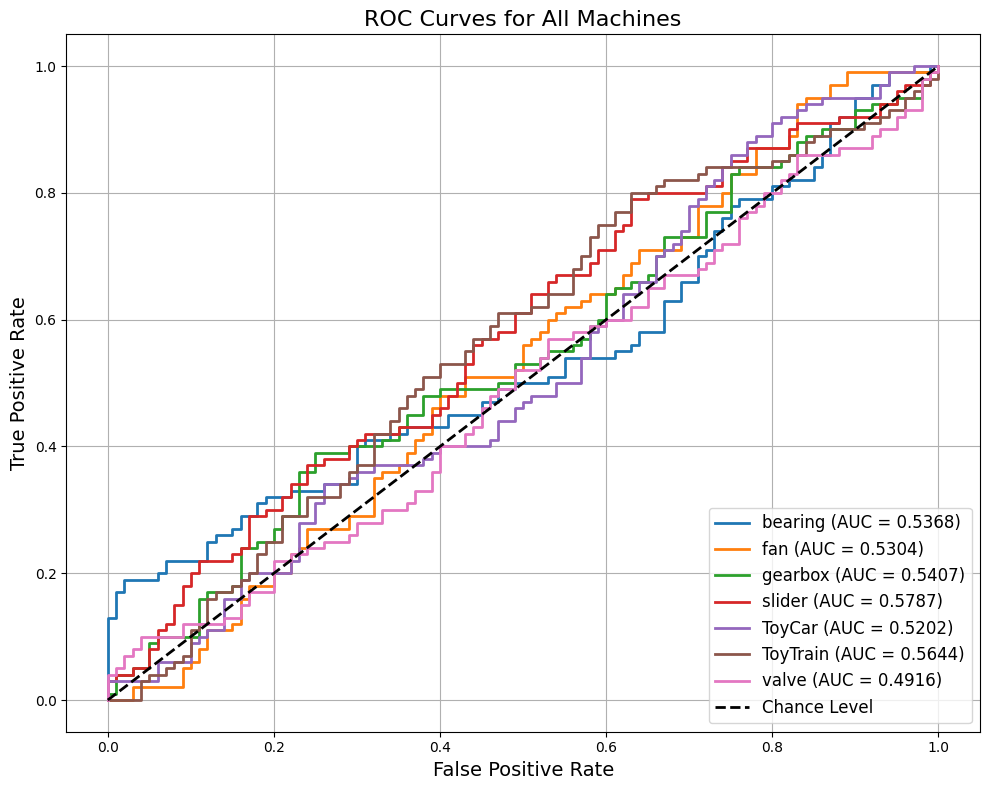

Machine: bearing
Thresholds: 16.65386390686035
AUC: 0.5368

Machine: fan
Thresholds: 9.073600769042969
AUC: 0.5304

Machine: gearbox
Thresholds: 10.441597938537598
AUC: 0.5407

Machine: slider
Thresholds: 10.299590110778809
AUC: 0.5787

Machine: ToyCar
Thresholds: 9.526611328125
AUC: 0.5202

Machine: ToyTrain
Thresholds: 9.343228340148926
AUC: 0.5644

Machine: valve
Thresholds: 9.80606460571289
AUC: 0.49160000000000004



In [37]:
plt.figure(figsize=(10, 8))

for i, machine in enumerate(machines):
    plt.plot(roc_fprs[i], roc_tprs[i], lw=2, label=f'{machine} (AUC = {auc_scores[i]:.4f})')

# Plot chance level line
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Chance Level')

# Customize the plot
plt.title('ROC Curves for All Machines', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

#> Print Thresholds
for i, machine in enumerate(machines):
    print(f"Machine: {machine}")
    print(f"Thresholds: {all_thresholds[i]}")
    print(f"AUC: {auc_scores[i]}")
    print()

C:\Users\Mikkel\AppData\Local\Temp\ipykernel_2052\3757668449.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for the color bar


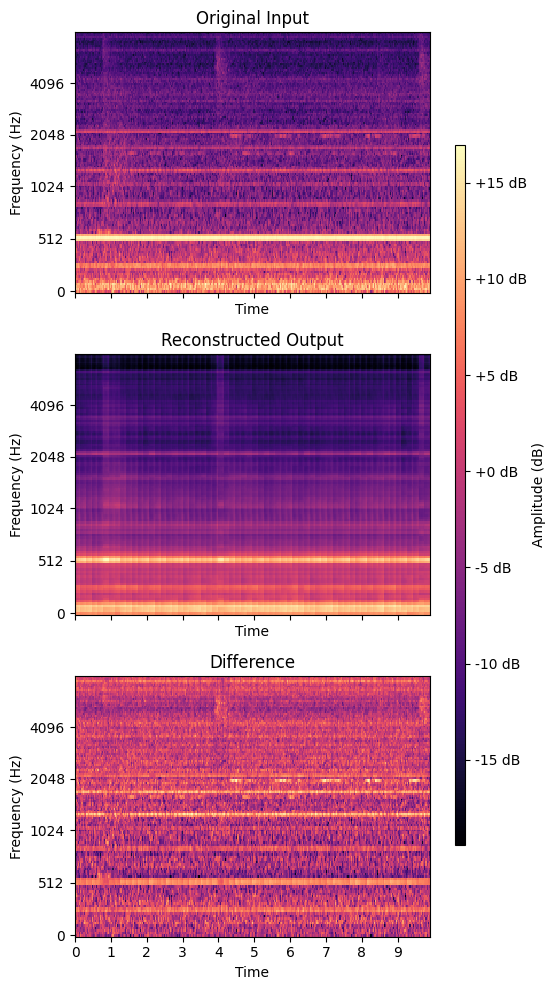

section_00_target_test_normal_0025_v1pat_05_v2pat_05.wav


In [38]:
# Create a vertical layout for the spectrogram plots
spectrogram_figures, axes = plt.subplots(3, 1, figsize=(5, 10), sharex=True, sharey=True)

# Plot each spectrogram
titles = ['Original Input', 'Reconstructed Output', 'Difference']

for ax, spectrogram, title in zip(axes, spectrograms, titles):
    img = librosa.display.specshow(
        spectrogram,
        sr=16000,
        x_axis='time',
        y_axis='mel',
        cmap='magma',
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency (Hz)')

# Add a colorbar beside the plots
cbar_ax = spectrogram_figures.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = spectrogram_figures.colorbar(img, cax=cbar_ax, format='%+2.0f dB')
cbar.set_label('Amplitude (dB)')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for the color bar
plt.show()

# Print the filename associated with the spectrogram
print(testing_filenames[audio_clip_index])